## Логистическая регрессия

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12,5)

Реализуйте обучение логистической регрессии с $L^1$ и $L^2$ регуляризацией с помощью метода Stochastic Gradient Descent (SGD)

#### Замечания
* В SGD градиент расчитывается по одному случайному объекту
* Для отладки работы алгоритма, реализуйте возможность сохранения или вывода ошибки модели после очередной итерации
* Правило останова - максимальное количество эпох
    
Эпохой в SGD и MB-SGD называется один проход по **всем** объектам в выборке (тем или иным способом)

# Реализация модели

## Регуляризация
- $L_1$
- $L_2$

К функционалу ошибки добавляем некоторый функционал от $\theta$:

$$Q + \lambda \theta ^ 2$$

Возьмем $C = \frac {1} {\lambda}$ и получим оптимизационную задачу:
$$ \theta = \arg min_{theta} {Q(x, y, \theta)} = C * Q(x, y, \theta) + \theta ^ 2$$

In [64]:
from sklearn.base import BaseEstimator, ClassifierMixin

class MySGDClassifier(BaseEstimator, ClassifierMixin):
    """
    Предполагается, что в выборке всегда 2 класса
    """
    
    def __init__(self, C=1, alpha=0.1, max_epoch=20, penalty='l2'):
        """
        C - коэф. регуляризации
        alpha - скорость спуска
        max_epoch - максимальное количество эпох
        """
        
        self.C = C
        self.alpha = alpha
        self.max_epoch = max_epoch
        self.penalty = penalty
    
    def f_sigma(self, t):
        '''
        Сигмоидальная функция
        '''
        
        s = 1/(1+np.exp(-t))
        return s
    
    def f_regularize(self, theta):
        '''
        Подбор параметра регуляризации в зависимости от типа
        '''
        
        # in a list 1 value - for theta, 2 value - for costs counting
        if self.penalty == 'l1':
            f = self.C*np.sign(theta)
        elif self.penalty == 'l2':
            f = self.C*theta
        return f
    
    def fit(self, X, y=None):
        '''
        Обучение модели
        '''
        
        np.random.seed(0)
        m = len(X)
        X = np.hstack([np.ones(m).reshape(-1, 1), X])
        theta = np.random.randn(X.shape[1])
        self.costs = []
        
        for epoch in range(self.max_epoch):
            p = np.random.permutation(m) # take random string numbers
            for idx in p: # for each string
                xi = X[[idx], :] # take independent variables' values from string
                yi = y[idx] # take target value from string
                y_hat = self.f_sigma(xi.dot(theta))
                gradient = (xi.T.dot(y_hat - yi))
                theta = theta - self.alpha * (gradient + self.f_regularize(theta)) # correct coefficients
                
            cost = (-y*np.log(self.f_sigma(X.dot(theta))) - (1-y)*np.log(1 - self.f_sigma(X.dot(theta)))).mean()
            self.costs.append(cost)
                
        self.coef = theta[1:]
        self.intercept = theta[0]
        
        return self
        
    def predict(self, X):
        '''
        Возвращение метки класса
        '''

        x = np.hstack([np.ones(len(X)).reshape(-1, 1),X])
        y_hat = np.round(self.f_sigma(x.dot(np.hstack([self.intercept, self.coef]))))
        
        return y_hat
    
    def predict_proba(self, X):
        '''
        Возвращение вероятности каждого из классов
        '''
        x = np.hstack([np.ones(len(X)).reshape(-1, 1),X])
        y_hat_proba = self.f_sigma(x.dot(np.hstack([self.intercept, self.coef])))
        return y_hat_proba

## Проверка на синтетических данных (2 балл)

Запустите ваш алгоритм на синтетических данных. 
Выведите полученные веса и нарисуйте разделяющую границу между классами.

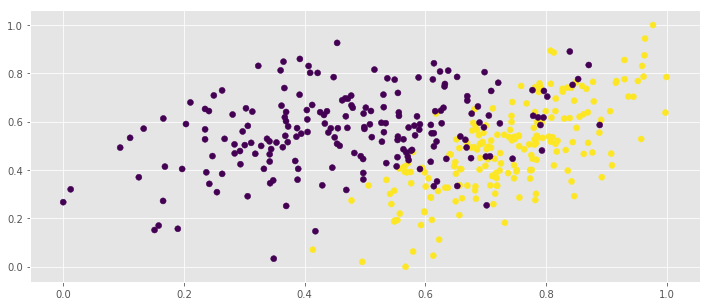

In [65]:
np.random.seed(0)

C1 = np.array([[0., -0.8], [1.5, 0.8]])
C2 = np.array([[1., -0.7], [2., 0.7]])
gauss1 = np.dot(np.random.randn(200, 2) + np.array([5, 3]), C1)
gauss2 = np.dot(np.random.randn(200, 2) + np.array([1.5, 0]), C2)

X = np.vstack([gauss1, gauss2])
y = np.r_[np.ones(200), np.zeros(200)]

X = MinMaxScaler().fit_transform(X)

plt.scatter(X[:,0], X[:,1], c = y)
plt.show()

In [73]:
model = MySGDClassifier(C = 0.1, alpha = 0.1, max_epoch = 10, penalty = 'l2')
model.fit(X, y)

MySGDClassifier(C=0.1, alpha=0.1, max_epoch=10, penalty='l2')

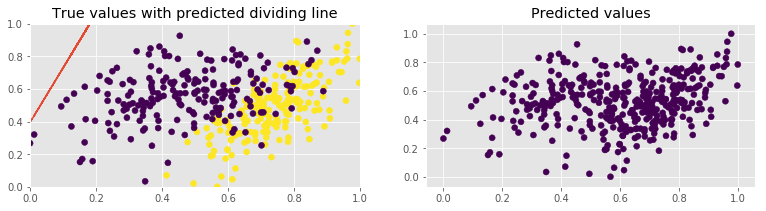

In [74]:
## Your Code Here
forecast = model.predict(X)
fig,ax=plt.subplots(1,2,figsize=(13,3))

ax[0].scatter(X[:, 0], X[:, 1], c = y)

axes = plt.gca()
x_vals = X[:, 0]
y_vals = - (model.intercept + model.coef[0] * x_vals)/model.coef[1]
ax[0].plot(x_vals, y_vals, '--')

ax[1].scatter(X[:, 0], X[:, 1], c = forecast)

ax[0].set_xlim(0, 1)
ax[0].set_ylim(0, 1)

ax[0].title.set_text('True values with predicted dividing line')
ax[1].title.set_text('Predicted values')

plt.show()

Посмотрим работу модели при разных значениях параметров:

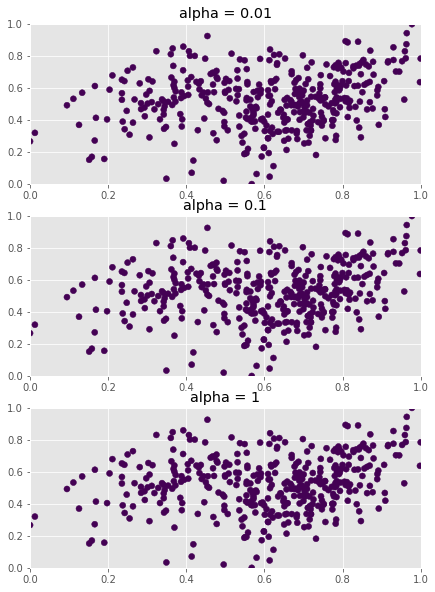

In [75]:
fig,ax=plt.subplots(3,1,figsize=(7,10))

model1 = MySGDClassifier(C = 1, alpha = 0.01, max_epoch = 10, penalty = 'l2')
model1.fit(X, y)
forecast1 = model1.predict(X)
ax[0].scatter(X[:, 0], X[:, 1], c = forecast1)

model2 = MySGDClassifier(C = 1, alpha = 0.1, max_epoch = 10, penalty = 'l2')
model2.fit(X, y)
forecast2 = model2.predict(X)
ax[1].scatter(X[:, 0], X[:, 1], c = forecast2)

model3 = MySGDClassifier(C = 1, alpha = 1, max_epoch = 10, penalty = 'l2')
model3.fit(X, y)
forecast3 = model3.predict(X)
ax[2].scatter(X[:, 0], X[:, 1], c = forecast3)

ax[0].title.set_text('alpha = 0.01')
ax[1].title.set_text('alpha = 0.1')
ax[2].title.set_text('alpha = 1')

for each in ax.flat:
    each.set_xlim(0, 1)
    each.set_ylim(0, 1)


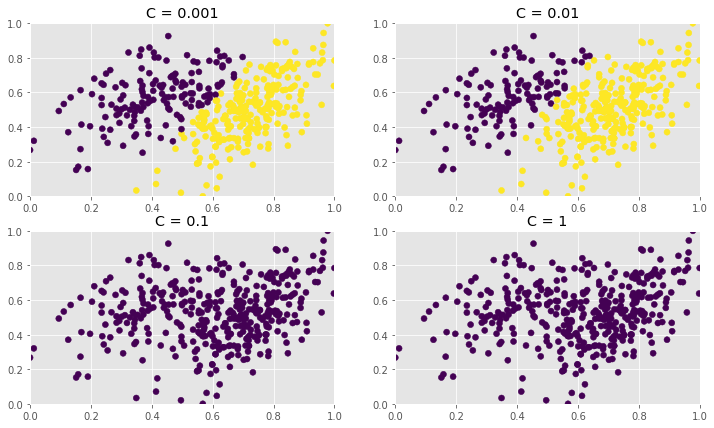

In [76]:
fig,ax=plt.subplots(2,2,figsize=(12,7))

model1 = MySGDClassifier(C = 0.001, alpha = 0.1, max_epoch = 10, penalty = 'l2')
model1.fit(X, y)
forecast1 = model1.predict(X)
ax[0][0].scatter(X[:, 0], X[:, 1], c = forecast1)

model2 = MySGDClassifier(C = 0.01, alpha = 0.1, max_epoch = 10, penalty = 'l2')
model2.fit(X, y)
forecast2 = model2.predict(X)
ax[0][1].scatter(X[:, 0], X[:, 1], c = forecast2)

model3 = MySGDClassifier(C = 0.1, alpha = 0.1, max_epoch = 10, penalty = 'l2')
model3.fit(X, y)
forecast3 = model3.predict(X)
ax[1][0].scatter(X[:, 0], X[:, 1], c = forecast3)

model4 = MySGDClassifier(C = 1, alpha = 0.1, max_epoch = 10, penalty = 'l2')
model4.fit(X, y)
forecast4 = model4.predict(X)
ax[1][1].scatter(X[:, 0], X[:, 1], c = forecast4)

ax[0][0].title.set_text('C = 0.001')
ax[0][1].title.set_text('C = 0.01')
ax[1][0].title.set_text('C = 0.1')
ax[1][1].title.set_text('C = 1')

for each in ax.flat:
    each.set_xlim(0, 1)
    each.set_ylim(0, 1)


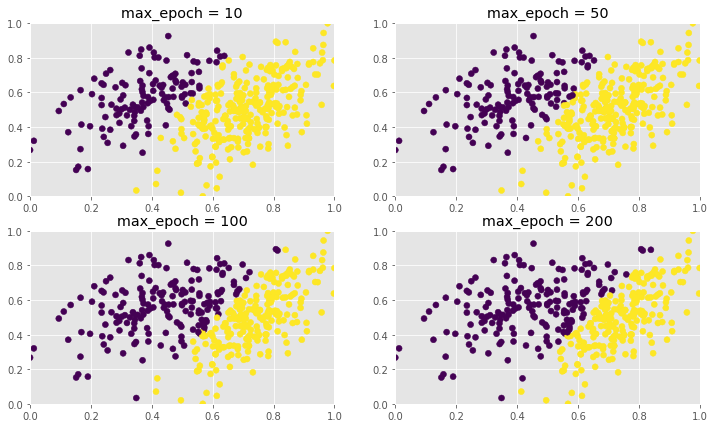

In [77]:
fig,ax=plt.subplots(2,2,figsize=(12,7))

model1 = MySGDClassifier(C = 0.01, alpha = 0.1, max_epoch = 10, penalty = 'l2')
model1.fit(X, y)
forecast1 = model1.predict(X)
ax[0][0].scatter(X[:, 0], X[:, 1], c = forecast1)

model2 = MySGDClassifier(C = 0.01, alpha = 0.1, max_epoch = 50, penalty = 'l2')
model2.fit(X, y)
forecast2 = model2.predict(X)
ax[0][1].scatter(X[:, 0], X[:, 1], c = forecast2)

model3 = MySGDClassifier(C = 0.01, alpha = 0.1, max_epoch = 100, penalty = 'l2')
model3.fit(X, y)
forecast3 = model3.predict(X)
ax[1][0].scatter(X[:, 0], X[:, 1], c = forecast3)

model4 = MySGDClassifier(C = 0.01, alpha = 0.1, max_epoch = 200, penalty = 'l2')
model4.fit(X, y)
forecast4 = model4.predict(X)
ax[1][1].scatter(X[:, 0], X[:, 1], c = forecast4)

ax[0][0].title.set_text('max_epoch = 10')
ax[0][1].title.set_text('max_epoch = 50')
ax[1][0].title.set_text('max_epoch = 100')
ax[1][1].title.set_text('max_epoch = 200')

for each in ax.flat:
    each.set_xlim(0, 1)
    each.set_ylim(0, 1)


Подобрав оптимальные параметры, построим модель на них: C = 0.001, alpha = 0.1, max_epoch = 20

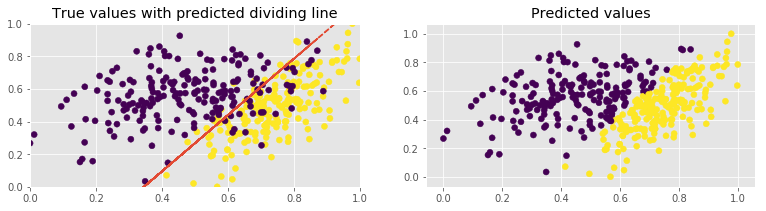

In [81]:
model = MySGDClassifier(C = 0.001, alpha = 0.1, max_epoch = 30, penalty = 'l2')
model.fit(X, y)
forecast = model.predict(X)
fig,ax=plt.subplots(1,2,figsize=(13,3))

ax[0].scatter(X[:, 0], X[:, 1], c = y)

axes = plt.gca()
x_vals = X[:, 0]
y_vals = - (model.intercept + model.coef[0] * x_vals)/model.coef[1]
ax[0].plot(x_vals, y_vals, '--')

ax[1].scatter(X[:, 0], X[:, 1], c = forecast)

ax[0].set_xlim(0, 1)
ax[0].set_ylim(0, 1)

ax[0].title.set_text('True values with predicted dividing line')
ax[1].title.set_text('Predicted values')

plt.show()

## Анализ сходимости

Покажите сходимость вашего метода: изобразите графики зависимости значения функции потерь (по всей выборке) после очередной итерации/эпохи (выбрать одно) для разных `alpha`.

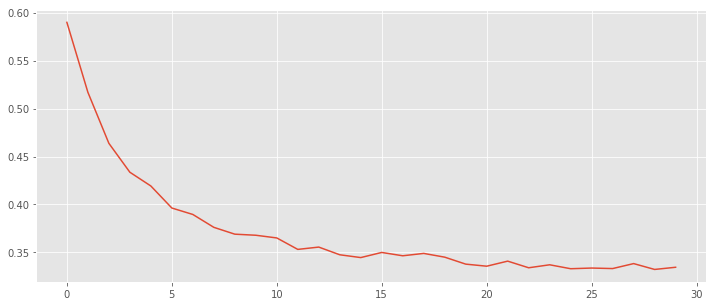

In [82]:
## Your Code Here
plt.plot(model.costs)